# Analyze Kaggle ELO Data - Classifying/Detecting outliers

### We will train our model to detect outliers on training data as well as testing data



In [24]:
import pandas as panda

import numpy as np

import datetime, time

from matplotlib import pyplot as plot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, \
    confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression, RANSACRegressor, SGDRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from numpy import bincount, linspace, mean, std, arange, squeeze
import warnings
warnings.simplefilter('ignore')


In [3]:
train_data_path = 'train_new_details_added.csv'
test_data_path = 'test_new_details_added.csv'

train_data = panda.read_csv(train_data_path)
test_data = panda.read_csv(test_data_path)
# train_data['max_cat_1'] = train_data.max_cat_1.apply(lambda x: 1 if x=='N' else 0)

train_data  = train_data[[i for i in train_data.columns.tolist() if i !='Unnamed: 0']]
train_data.head()

,card_id,feature_1,feature_2,feature_3,target,months_passed,total_no_of_transaction,total,total_accepted,total_rejects,mean_installments,max_cat_1,max_cat_2,cat_3,most_appearing_mc_id,mean_month_lag
0,C_ID_92A2005557,5,2,1,-0.820283,18,9,-4.135011,8,1,0.014134,1,5,3,560.0,-2.674121
1,C_ID_3D0044924F,4,1,0,0.392913,23,9,-4.135011,8,1,1.542135,0,1,3,307.0,-4.671642
2,C_ID_D639EDF6CD,2,2,0,0.688056,28,9,-4.135011,8,1,0.000000,1,5,3,705.0,-6.060827
3,C_ID_186D6A6901,4,3,0,0.142495,15,9,-4.135011,8,1,1.059524,0,4,3,278.0,-3.613181
4,C_ID_CDBD2C0DB2,1,3,0,-0.159749,13,9,-4.135011,8,1,1.284024,0,5,3,278.0,-2.531343


In [3]:
outliers = train_data[train_data['target'] < -29]

len(outliers)

2207

In [4]:
train_data['outlier'] = train_data.target.apply(lambda x: 1 if x <-29 else 0)

train_data.head()

,card_id,feature_1,feature_2,feature_3,target,months_passed,total_no_of_transaction,total,total_accepted,total_rejects,mean_installments,max_cat_1,max_cat_2,cat_3,most_appearing_mc_id,mean_month_lag,outlier
0,C_ID_92A2005557,5,2,1,-0.820283,18,9,-4.135011,8,1,0.014134,1,5,3,560.0,-2.674121,0
1,C_ID_3D0044924F,4,1,0,0.392913,23,9,-4.135011,8,1,1.542135,0,1,3,307.0,-4.671642,0
2,C_ID_D639EDF6CD,2,2,0,0.688056,28,9,-4.135011,8,1,0.000000,1,5,3,705.0,-6.060827,0
3,C_ID_186D6A6901,4,3,0,0.142495,15,9,-4.135011,8,1,1.059524,0,4,3,278.0,-3.613181,0
4,C_ID_CDBD2C0DB2,1,3,0,-0.159749,13,9,-4.135011,8,1,1.284024,0,5,3,278.0,-2.531343,0


In [4]:

## lets check the impact of each column on the target value and select only the ones which have direct impact

# sns.pairplot(train_data[[i for i in train_data.columns.tolist() if i not in['card_id','first_active_month', 'card_id.1','Unnamed:0'] ]])

In [38]:

##based off of the pairplots above we use only the columns -

# cols = ['months_passed','total_no_of_transaction',\
# #         'total',\
# #         'max_cat_2',\
#         'total_accepted','total_rejects',\
# #         'mean_installments'
#        ]

# without_outliers = train_data[train_data['target'] > -29]
# with_outliers = train_data[train_data['target'] < -29]

round1_x = train_data[[i for i in train_data.columns.tolist() if i not in ['card_id','target','outlier']]]

round1_y = train_data[['outlier']]

# # round1_x_train, round1_x_test, round1_y_train, round1_y_test = train_test_split(round1_x, round1_y, test_size = 0.3, random_state = 12)

# print(round1_x.shape, round1_y.shape)

In [39]:
round1_y.shape, round1_x.shape

((201917, 1), (201917, 14))

In [7]:

from math import sqrt

def root_mean_square_error(y, y_predicted):
    
    return sqrt(mean_squared_error(y,y_predicted))
    
scorer = make_scorer(root_mean_square_error, greater_is_better=False)

In [34]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(random_state = 1),
#     RandomForestClassifier(random_state = 1),
#     KNeighborsClassifier(metric = 'minkowski'),
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
    
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini',]},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
    
]

In [13]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [16]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
#     print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
        
    with predict_proba_timer:
        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            y_probability = gridsearch.predict_proba(x_test)
#             false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
#             response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
#             response['roc_curve'] = (false_positive_rate, true_positive_rate)
    
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = None
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['best_estimator'] = search.best_estimator_
    
    
    return response

In [35]:
_x_train,_x_test,_y_train,_y_test = train_test_split(round1_x,round1_y, test_size =0.2, random_state = 123)

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  1.0
Code block 'training' took(HH:MM:SS): 0:00:29.005871
Code block 'testing' took(HH:MM:SS): 0:00:00.022688
F1 score 1.0
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     39980
          1       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00     40384



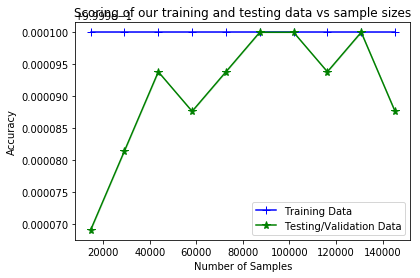

Code block 'learning_curve' took(HH:MM:SS): 0:00:33.088268
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000023
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  1.0
Code block 'training' took(HH:MM:SS): 0:00:47.053729
Code block 'testing' took(HH:MM:SS): 0:00:00.022056
F1 score 1.0
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     39980
          1       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00     40384



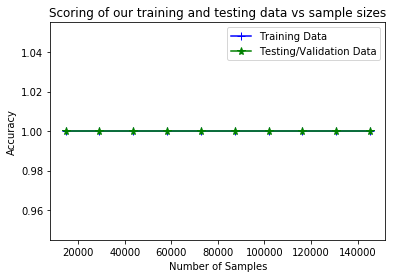

Code block 'learning_curve' took(HH:MM:SS): 0:01:17.540077
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.032242
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  1.0
Code block 'training' took(HH:MM:SS): 0:00:18.707982
Code block 'testing' took(HH:MM:SS): 0:00:00.025974
F1 score 1.0
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     39980
          1       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00     40384



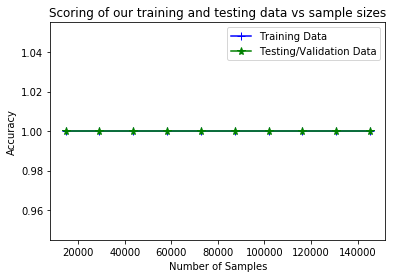

Code block 'learning_curve' took(HH:MM:SS): 0:00:31.606944
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.022760
Code block 'overalltime' took(HH:MM:SS): 0:04:05.578211


MemoryError: 

In [40]:
timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12)
        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , cv = cv,score = 'f1_weighted')

        _y_prediction = result['_y_prediction']

        _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction, labels = _y_test['outlier'].values)

        model_metrics[model_name] = {}
        model_metrics[model_name]['confusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
#         model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        model_metrics[model_name]['f1_score'] = result['f1_score']
#         model_metrics[model_name]['roc_auc_score'] = result['roc_auc_score']
#         model_metrics[model_name]['roc_curve'] = result['roc_curve']
        model_metrics[model_name]['best_estimator'] = result['best_estimator']
        
        
print(timer.took)


In [41]:
best_classifier =  DecisionTreeClassifier(criterion='gini', max_depth = 6)

In [42]:
test_data= panda.read_csv('test_new_details_added.csv')

test_data= test_data[[i for i in test_data.columns.tolist() if i not in ['Unnamed: 0','card_id','card_id.1']]]
test_data.head()

,feature_1,feature_2,feature_3,months_passed,total_no_of_transaction,total,total_accepted,total_rejects,mean_installments,max_cat_1,max_cat_2,cat_3,most_appearing_mc_id,mean_month_lag
0,3.0,3.0,1.0,20.0,9,-4.135011,8,1,2.056338,0,1.0,2,879.0,-7.130435
1,2.0,3.0,0.0,23.0,9,-4.135011,8,1,1.080460,0,4.0,2,705.0,-2.009238
2,5.0,1.0,1.0,16.0,9,-4.135011,8,1,3.666667,0,5.0,3,529.0,-5.956221
3,2.0,1.0,0.0,12.0,9,-4.135011,8,1,1.861111,0,5.0,3,307.0,-2.750000
4,5.0,1.0,1.0,36.0,9,-4.135011,8,1,1.077586,1,4.0,3,705.0,-2.796178


In [43]:
round1_x.shape, test_data.shape

((201917, 14), (123623, 14))

In [44]:
scaled_test_data = StandardScaler().fit_transform(test_data)

best_classifier.fit(round1_x,round1_y)
test_target = best_classifier.predict_proba(test_data)

test_target

array([[0.9766881 , 0.0233119 ],
       [0.95854852, 0.04145148],
       [0.99090157, 0.00909843],
       ...,
       [0.99006963, 0.00993037],
       [0.99006963, 0.00993037],
       [0.99006963, 0.00993037]])

In [49]:
[i for i in test_target if i[0]<0.6]

[array([0.33333333, 0.66666667]),
 array([0., 1.]),
 array([0.5, 0.5]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.33333333, 0.66666667]),
 array([0.33333333, 0.66666667])]

In [51]:
test_target[np.where(test_target[:,0]<0.6)],np.where(test_target[:,0]<0.6)

(array([[0.33333333, 0.66666667],
        [0.        , 1.        ],
        [0.5       , 0.5       ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.33333333, 0.66666667],
        [0.33333333, 0.66666667]]),
 (array([  8133,  12231,  22897,  27446,  27452,  38455,  45306,  76591,
         110059, 114531], dtype=int64),))

In [ ]:
np.save

In [27]:
## write it to a panda table

temp = panda.read_csv('all/test.csv')
sample_submission_round_1 = temp[['card_id']]

# sample_submission_round_1 = test_data[['card_id']]
sample_submission_round_1['target'] = test_target


print(len(sample_submission_round_1), sample_submission_round_1.head())

sample_submission_round_1.to_csv('round_new_details_robust_scaler_elastic_net_submission.csv')

C:\Users\somak\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


123623            card_id    target
0  C_ID_0ab67a22ab -0.447552
1  C_ID_130fd0cbdd -0.448892
2  C_ID_b709037bc5 -0.445766
3  C_ID_d27d835a9f -0.443979
4  C_ID_2b5e3df5c2 -0.454698


In [ ]:

mean_installment_path = 'all/mean_installments.csv'
max_category_1_path = 'all/max_category_1.csv'
max_category_2_path = 'all/max_category_2.csv'
max_category_3_path = 'all/max_category_3.csv'

mean_installment = panda.read_csv(mean_installment_path)
max_category_1 = panda.read_csv(max_category_1_path)# = 'all/max_category_1.csv'
max_category_2 = panda.read_csv(max_category_2_path)# = 'all/max_category_2.csv'
max_category_3 = panda.read_csv(max_category_3_path)# = 'all/max_category_3.csv'




test_data = panda.read_csv('all/test_all_merged.csv')



test_installment_merged = test_data.merge(mean_installment, how='inner', on ='card_id')


test_max_category_merged = test_installment_merged.merge(max_category_1, on='card_id', how ='inner')


test_max_category_2_merged = test_max_category_merged.merge(max_category_2, on='card_id', how ='inner')


test_max_category_3_merged = test_max_category_2_merged.merge(max_category_3, on='card_id', how ='inner')



cols = [
 'card_id',
 'feature_1',
 'feature_2',
 'feature_3',
 'months_passed',
 'total_no_of_transaction',
 'total',
 'total_accepted',
 'total_rejects',
 'mean_installments',
 'max_cat_1',
 'max_cat_2',
 'cat_3',]

    
test_x = test_max_category_3_merged[cols]


test_x['max_cat_1'] = test_x.max_cat_1.apply(lambda x: 1 if x=='N' else 0)
test_x.head()



In [ ]:
test_x.to_csv('all/test_can_be_used_as_is_card_id_added.csv')

In [ ]:
test_target = best_estimator.predict(test_x[[i for i in test_x.columns.tolist() if i!='card_id']])

test_target

## write it to a panda table

sample_submission_round_1 = test_x[['card_id']]

# sample_submission_round_1 = test_data[['card_id']]
sample_submission_round_1['target'] = test_target


print(len(sample_submission_round_1), sample_submission_round_1.head())

sample_submission_round_1.to_csv('round_dealt_with_outliers_LR_submission.csv')